In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Attention, Input
from tensorflow.python.ops.init_ops import he_normal
from keras.backend import concatenate
import keras.backend as K

In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.177)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


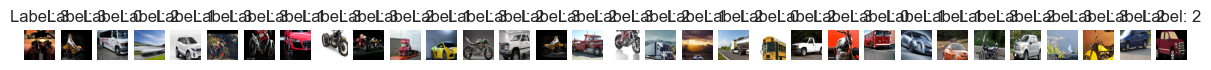

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = Attention()([x, x])
    x = x + att
    
    return x


In [7]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
      
    att = Attention()([x, x])
    x = x + att
    
    return x


In [8]:
def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    
    att = Attention()([x, x])
    x = x + att
    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage

combined_model = create_combined_model(input_shape)

In [9]:

def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)

def custom_accuracy(y_true, y_pred):
    # Assuming one-hot encoded vectors
    true_labels = tf.argmax(y_true, axis=-1)
    predicted_labels = tf.argmax(y_pred, axis=-1)

    # Check if the predicted labels match the true labels
    accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))
    
    return accuracy

In [10]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
from keras.optimizers import Adam
new_learning_rate = 0.001  # 设置你想要的学习率
custom_optimizer = Adam(lr=new_learning_rate)

# Compile the model
combined_model.compile(optimizer='Adam', 
              loss=custom_categorical_crossentropy, 
              metrics=[custom_accuracy]
              )

C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# Train the model
history_my_model = combined_model.fit(train_generator, validation_data=(val_generator), epochs=40)

Epoch 1/40
9/9 [==============================] - 25s 2s/step - loss: 3.2744 - custom_accuracy: 0.2809 - val_loss: 1.5203 - val_custom_accuracy: 0.2406
Epoch 2/40
9/9 [==============================] - 32s 3s/step - loss: 1.4107 - custom_accuracy: 0.2704 - val_loss: 1.3777 - val_custom_accuracy: 0.3119
Epoch 3/40
9/9 [==============================] - 29s 3s/step - loss: 1.3791 - custom_accuracy: 0.3164 - val_loss: 1.3726 - val_custom_accuracy: 0.4162
Epoch 4/40
9/9 [==============================] - 32s 4s/step - loss: 1.3642 - custom_accuracy: 0.2886 - val_loss: 1.3479 - val_custom_accuracy: 0.3519
Epoch 5/40
9/9 [==============================] - 25s 3s/step - loss: 1.3316 - custom_accuracy: 0.4028 - val_loss: 1.3088 - val_custom_accuracy: 0.3319
Epoch 6/40
9/9 [==============================] - 21s 2s/step - loss: 1.2755 - custom_accuracy: 0.4174 - val_loss: 1.4840 - val_custom_accuracy: 0.3119
Epoch 7/40
9/9 [==============================] - 21s 2s/step - loss: 1.2347 - custom_ac

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

9/9 [==============================] - 17s 2s/step - loss: 0.4095 - custom_accuracy: 0.8538
Test Accuracy: 0.8537808656692505
Test loss: 0.40945184230804443


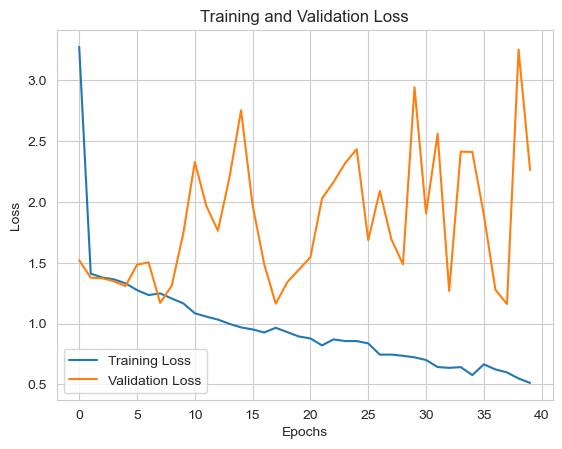

In [14]:
plt.plot(history_my_model.history['loss'], label='Training Loss')
plt.plot(history_my_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

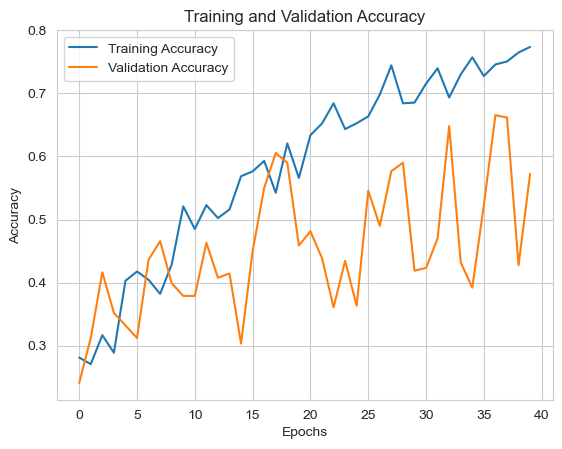

In [15]:
plt.plot(history_my_model.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history_my_model.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve

NameError: name 'history_vgg' is not defined

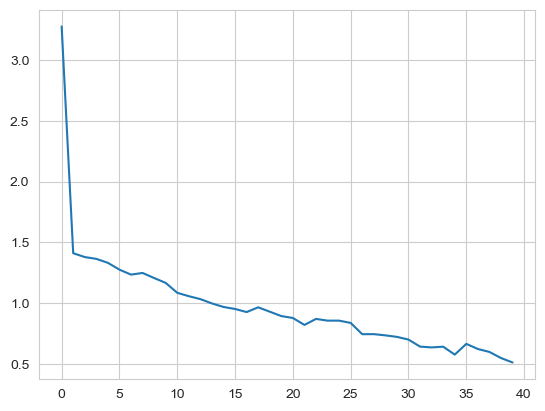

In [17]:
# Plot Training and Validation Loss
plt.plot(history_my_model.history['loss'], label='My_Training Loss')
plt.plot(history_vgg.history['loss'], label='VGG_Training Loss')
plt.plot(history_resNet.history['loss'], label='ResNet_Training Loss')
plt.plot(history_effNet.history['loss'], label='EffNet_Training Loss')
plt.plot(history_my_model.history['val_loss'], label='My_Validation Loss')
plt.plot(history_vgg.history['val_loss'], label='VGG_Validation Loss')
plt.plot(history_resNet.history['val_loss'], label='ResNet_Validation Loss')
plt.plot(history_effNet.history['val_loss'], label='EffNet_Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_my_model.history['loss'], label='My_Training Loss')
plt.plot(history_vgg.history['loss'], label='VGG_Training Loss')
plt.plot(history_resNet.history['loss'], label='ResNet_Training Loss')
plt.plot(history_effNet.history['loss'], label='EffNet_Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_my_model.history['val_loss'], label='My_Validation Loss')
plt.plot(history_vgg.history['val_loss'], label='VGG_Validation Loss')
plt.plot(history_resNet.history['val_loss'], label='ResNet_Validation Loss')
plt.plot(history_effNet.history['val_loss'], label='EffNet_Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot Training and Validation Accuracy
plt.plot(history_my_model.history['custom_accuracy'], label='My_Training Accuracy')
plt.plot(history_vgg.history['accuracy'], label='VGG_Training Accuracy')
plt.plot(history_resNet.history['accuracy'], label='ResNet_Training Accuracy')
plt.plot(history_effNet.history['accuracy'], label='effNet_Training Accuracy')
plt.plot(history_my_model.history['val_custom_accuracy'], label='My_Validation Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='VGG_Validation Accuracy')
plt.plot(history_resNet.history['val_accuracy'], label='ResNet_Validation Accuracy')
plt.plot(history_effNet.history['val_accuracy'], label='EffNet_Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_my_model.history['custom_accuracy'], label='My_Training Accuracy')
plt.plot(history_vgg.history['accuracy'], label='VGG_Training Accuracy')
plt.plot(history_resNet.history['accuracy'], label='ResNet_Training Accuracy')
plt.plot(history_effNet.history['accuracy'], label='effNet_Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_my_model.history['val_custom_accuracy'], label='My_Validation Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='VGG_Validation Accuracy')
plt.plot(history_resNet.history['val_accuracy'], label='ResNet_Validation Accuracy')
plt.plot(history_effNet.history['val_accuracy'], label='EffNet_Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, num_classes):
    plt.figure(figsize=(8, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = combined_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [ ]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = vgg_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [ ]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = resNet_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [ ]:
# Evaluate the model on the test set
test_generator.reset()
y_prob = combined_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = effNet_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Report:")
print(classification_report(y_true, y_pred))

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Extract true negatives, false positives, false negatives, and true positives based on the shape
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [ ]:
# combined_model.save("model90.h5")